# 0. Import & install

In [50]:
# pip install pyarrow

In [52]:
import dask.dataframe as dd#similar to pandas

import pandas as pd#pandas to create small dataframes 

# unix time: https://www.unixtimestamp.com/
import datetime #Convert to unix time

import time #Convert to unix time

# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays

from matplotlib import rcParams#Size of plots  

import matplotlib.pylab as plt
import seaborn as sns#Plots

from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os

# to install sklearn: pip install -U scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# 1. Data Load

In [53]:
df = pd.read_parquet('yellow_tripdata_2019-01.parquet', engine='pyarrow') 

In [54]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN,None
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN,None
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN,None
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN,None
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN,None


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7696617 entries, 0 to 7696616
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [55]:
df.isna().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count            28672
trip_distance                  0
RatecodeID                 28672
store_and_fwd_flag         28672
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge     4884887
airport_fee              7696617
dtype: int64

# 2. preprocess

In [56]:
df=df.query("tpep_pickup_datetime >= '2019-01-01' and tpep_pickup_datetime <='2019-12-31'")
df=df.query("tpep_dropoff_datetime >= '2019-01-01' and tpep_dropoff_datetime <='2019-12-31'")

In [61]:
#The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning 

# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert thiss sting to python time formate and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    s = np.datetime_as_string(s, unit='s')
    s = s.replace('T', ' ')
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())




# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed' : velocity of each trip
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']]
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','PULocationID','DOLocationID','total_amount']]
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

frame_with_durations = return_with_trip_times(df)
print(frame_with_durations.head())

   passenger_count  trip_distance  PULocationID  DOLocationID  total_amount  \
0              1.0            1.5           151           239          9.95   
1              1.0            2.6           239           246         16.30   
7              1.0            1.3           163           229          9.05   
8              1.0            3.7           229             7         18.50   
9              2.0            2.1           141           234         13.00   

   trip_times  pickup_times      Speed  
0    6.666667  1.546271e+09  13.500000  
1   19.200000  1.546272e+09   8.125000  
7    7.150000  1.546270e+09  10.909091  
8   13.633333  1.546270e+09  16.283619  
9   12.000000  1.546272e+09  10.500000  


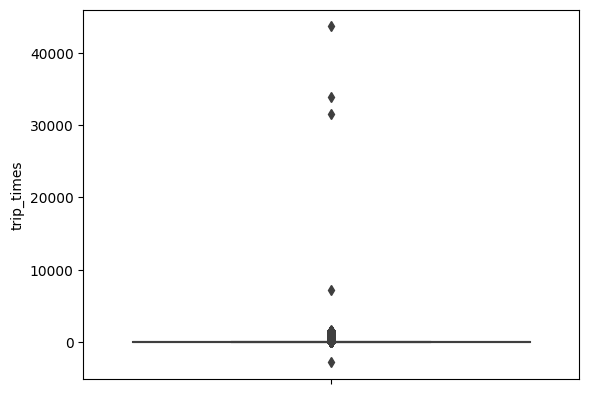

In [62]:
sns.boxplot(y="trip_times", data =frame_with_durations)
plt.show()